<h2 style="font-family: 'Arial', sans-serif; text-align: center; color: #4B8BBE;">
    Áp dụng mô hình RFM kết hợp thuật toán K-means trong phân khúc khách hàng cho doanh nghiệp
</h2>

## Các bước thực hiện

### 1. Đọc dữ liệu

### 2. Tiền xử lý dữ liệu và tính toán các chỉ số RFM
- **Tính toán các chỉ số của mô hình RFM**
- **Vẽ biểu đồ histplot để kiểm tra phân phối dữ liệu**
- **Đánh giá độ lệch phân phối và lựa chọn phương pháp biến đổi phù hợp**
- **Chuẩn hóa dữ liệu**

### 3. Áp dụng thuật toán K-means
- **Xác định số nhóm tối ưu (K) bằng phương pháp Elbow**
- **Phân nhóm khách hàng với K-means**
- **Trực quan hóa 3D kết quả phân nhóm**
- **Đánh giá chất lượng phân nhóm**


###  **Đọc dữ liệu và trích chọn các thuộc tính cần thiết**

In [ ]:
#Khai báo các thư viện 
import datetime as dt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
import plotly.express as px
import redshift_connector


conn = redshift_connector.connect(
    host     = "datnvn.870889396351.us-east-1.redshift-serverless.amazonaws.com",
    port     = 5439,
    database = "dev",
    user     = "admin",
    password  = 'Datn1234'
)

cursor = conn.cursor()
cursor.execute("SELECT *  FROM  Fact_BanHang ")
df = cursor.fetch_dataframe()
df.head(5)


,matg,madh,macn,manv,masp,makh,soluong,doanhthu,loinhuan
0,20221001,ĐH6836246,CN DN,NV087,P-546,KH-0330,10,2.400000e+06,800000.0
1,20221001,ĐH8764088,CN DN,NV055,P-160,KH-0082,5,1.440750e+09,480250000.0
2,20221001,ĐH6632564,CN DN,NV162,P-490,KH-0203,5,9.213750e+08,307125000.0
3,20221001,ĐH9819562,CN DN,NV213,P-206,KH-0208,7,5.460000e+06,1820000.0
4,20221001,ĐH6107309,CN DN,NV217,P-224,KH-0018,7,9.345000e+06,3115000.0


***Hiển thị thông tin tổng quan về dataFrame***

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29129 entries, 0 to 29128
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   matg      29129 non-null  int64  
 1   madh      29129 non-null  object 
 2   macn      29129 non-null  object 
 3   manv      29129 non-null  object 
 4   masp      29129 non-null  object 
 5   makh      29129 non-null  object 
 6   soluong   29129 non-null  int64  
 7   doanhthu  28956 non-null  float64
 8   loinhuan  29125 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 2.0+ MB


###  **Tiền xử lý Dữ liệu**

**Tính toán các chỉ số RFM**

In [ ]:
# Chuyển đổi ngày từ định dạng 'YYYYmmdd' thành datetime
df['matg'] = pd.to_datetime(df['matg'], format='%Y%m%d')

# Tính Recency
ngay_hien_tai = df['matg'].max() + dt.timedelta(days=1)
df['Recency'] = (ngay_hien_tai - df['matg']).dt.days

# Tính Frequency
frequency = df.groupby('makh')['madh'].nunique()

# Tính Monetary
monetary = df.groupby('makh')['doanhthu'].sum()

# Tạo DataFrame với các chỉ số RFM
rfm_df = pd.DataFrame({
    'Recency': df.groupby('makh')['Recency'].min(), 
    'Frequency': frequency,
    'Monetary': monetary
}).reset_index()

rfm_df

,makh,Recency,Frequency,Monetary
0,KH-0001,32,14,2.531355e+09
1,KH-0002,29,10,1.017435e+09
2,KH-0003,11,6,2.130150e+08
3,KH-0004,62,13,1.054656e+10
4,KH-0005,7,20,6.737760e+09
...,...,...,...,...
781,KH-0782,35,10,2.438295e+09
782,KH-0783,21,15,5.383305e+09
783,KH-0784,14,21,2.727300e+09
784,KH-0785,47,12,3.914265e+09


**Kiểm tra phân phối dữ liệu**

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_4224\2321466521.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm_df['Recency'], ax = ax[0])
c:\Users\ADMIN\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_4224\2321466521.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
simi

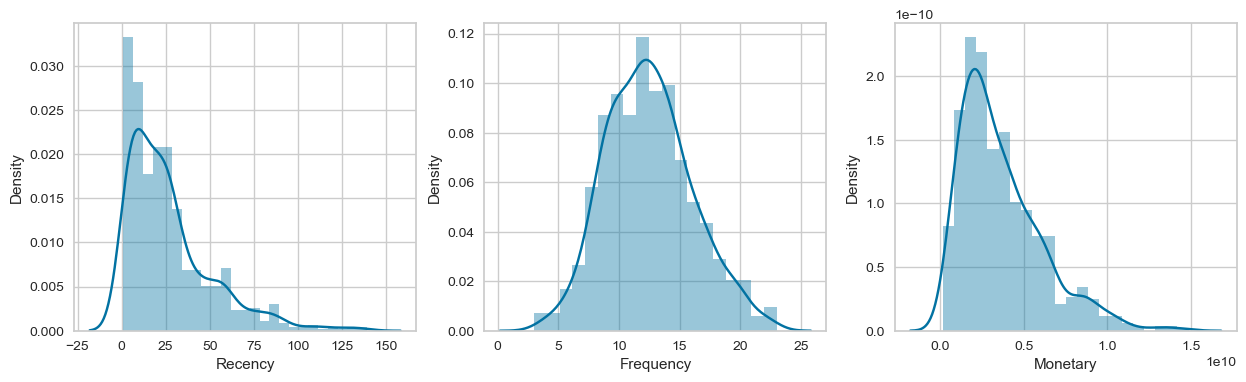

In [6]:

fig, ax = plt.subplots(1, 3, figsize=(15,4))
# Recency distribution
sns.distplot(rfm_df['Recency'], ax = ax[0])
# Frequency dstribution
sns.distplot(rfm_df['Frequency'], ax = ax[1])
# Monetary distribution
sns.distplot(rfm_df['Monetary'], ax = ax[2])
plt.show()


**Lựa chọn phương pháp biến đổi**

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_4224\3486914850.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm_df[x], ax=ax[0, 0])
c:\Users\ADMIN\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_4224\3486914850.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar fle

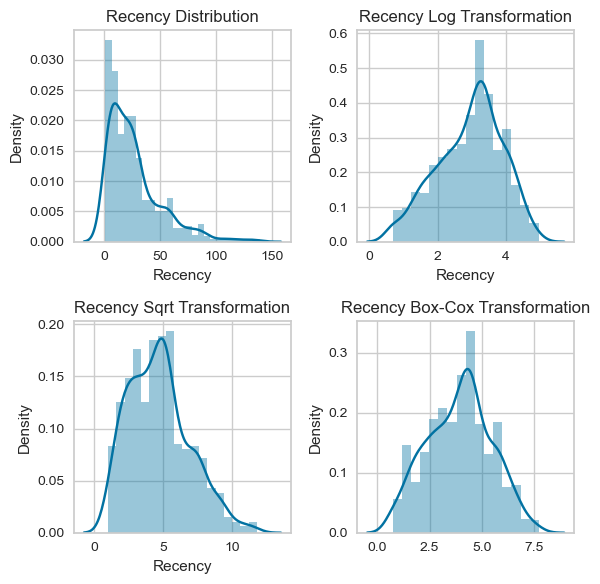

Recency Skewness (original): 1.6
Recency Skewness (log): -0.37
Recency Skewness (sqrt): 0.55
Recency Skewness (Box-Cox): -0.03


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_4224\3486914850.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm_df[x], ax=ax[0, 0])
c:\Users\ADMIN\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_4224\3486914850.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar fle

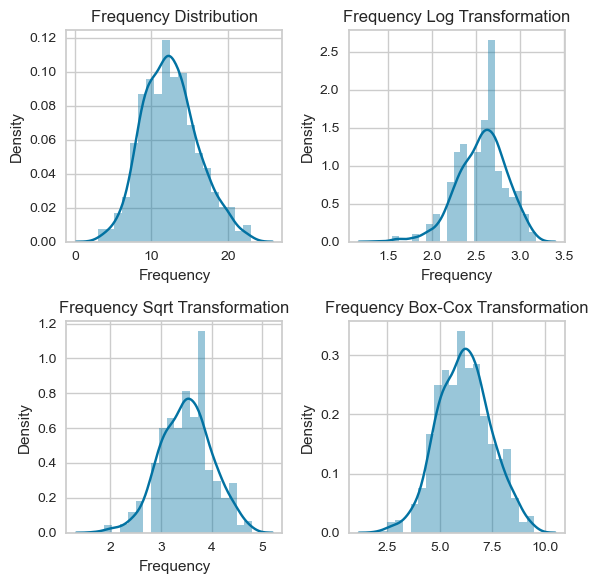

Frequency Skewness (original): 0.3
Frequency Skewness (log): -0.53
Frequency Skewness (sqrt): -0.12
Frequency Skewness (Box-Cox): -0.0


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_4224\3486914850.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm_df[x], ax=ax[0, 0])
c:\Users\ADMIN\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_4224\3486914850.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar fle

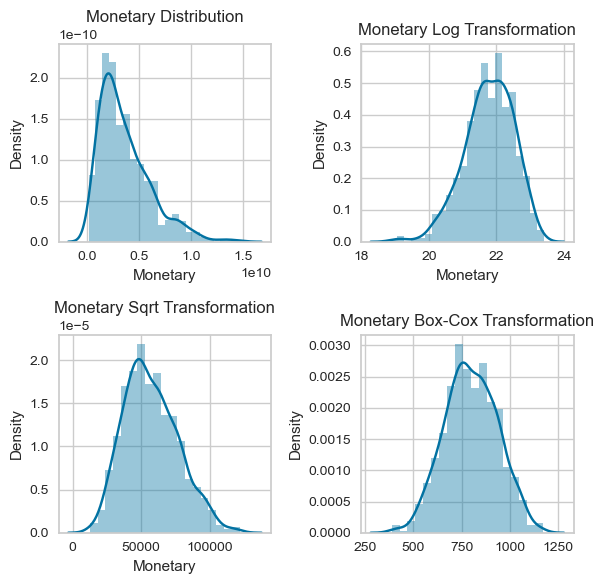

Monetary Skewness (original): 1.24
Monetary Skewness (log): -0.51
Monetary Skewness (sqrt): 0.44
Monetary Skewness (Box-Cox): -0.02


In [7]:
def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(6, 6))

    # Vẽ phân phối gốc
    sns.distplot(rfm_df[x], ax=ax[0, 0])
    ax[0, 0].set_title(f'{x} Distribution')

    # Vẽ phân phối sau log transformation
    sns.distplot(np.log1p(rfm_df[x]), ax=ax[0, 1])
    ax[0, 1].set_title(f'{x} Log Transformation')

    # Vẽ phân phối sau sqrt transformation
    sns.distplot(np.sqrt(rfm_df[x]), ax=ax[1, 0])
    ax[1, 0].set_title(f'{x} Sqrt Transformation')

    # Vẽ phân phối sau Box-Cox transformation
    boxcox_transformed = stats.boxcox(rfm_df[x] + 1)[0]
    sns.distplot(boxcox_transformed, ax=ax[1, 1])
    ax[1, 1].set_title(f'{x} Box-Cox Transformation')

    plt.tight_layout()
    plt.show()

    # In ra độ lệch của dữ liệu
    print(f"{x} Skewness (original): {rfm_df[x].skew().round(2)}")
    print(f"{x} Skewness (log): {np.log1p(rfm_df[x]).skew().round(2)}")
    print(f"{x} Skewness (sqrt): {np.sqrt(rfm_df[x]).skew().round(2)}")

    # Sửa lỗi và tính skewness cho Box-Cox
    boxcox_series = pd.Series(boxcox_transformed)
    print(f"{x} Skewness (Box-Cox): {boxcox_series.skew().round(2)}")

# Phân tích độ lệch cho các chỉ số RFM
analyze_skewness('Recency')
analyze_skewness('Frequency')
analyze_skewness('Monetary')


In [8]:
rfm_data=pd.DataFrame()
# Tranform Recency to box-cox transformation 
rfm_data['Recency']=stats.boxcox(rfm_df['Recency'])[0]
# Tranform Frequency to box-cox transformation 
rfm_data['Frequency']=stats.boxcox(rfm_df['Frequency'])[0]
# Tranform Monetary to box-cox transformation 
rfm_data['Monetary']=stats.boxcox(rfm_df['Monetary'])[0]
print(rfm_data)

      Recency  Frequency     Monetary
0    5.299149   6.809190   762.570172
1    5.083255   5.201090   611.331451
2    3.198903   3.328856   418.045397
3    6.883560   6.425063  1077.369909
4    2.453941   8.932018   966.640994
..        ...        ...          ...
781  5.499976   5.201090   755.678615
782  4.408675   7.183351   915.517068
783  3.629208   9.261436   776.474745
784  6.190603   6.029904   847.514402
785  3.198903   8.254394   957.126395

[786 rows x 3 columns]


In [9]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data[['Recency', 'Frequency', 'Monetary']])

# Hiển thị dữ liệu đã chuẩn hóa
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])
rfm_scaled_df

,Recency,Frequency,Monetary
0,0.536951,0.471661,-0.267459
1,0.426411,-0.664882,-1.378250
2,-0.538390,-1.988106,-2.797861
3,1.348181,0.200175,2.044624
4,-0.919816,1.971995,1.231362
...,...,...,...
781,0.639776,-0.664882,-0.318075
782,0.081022,0.736104,0.855877
783,-0.318071,2.204814,-0.165336
784,0.993382,-0.079109,0.356423


***Xác định số nhóm (k) tối ưu dựa vào phương pháp Elbow***

c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

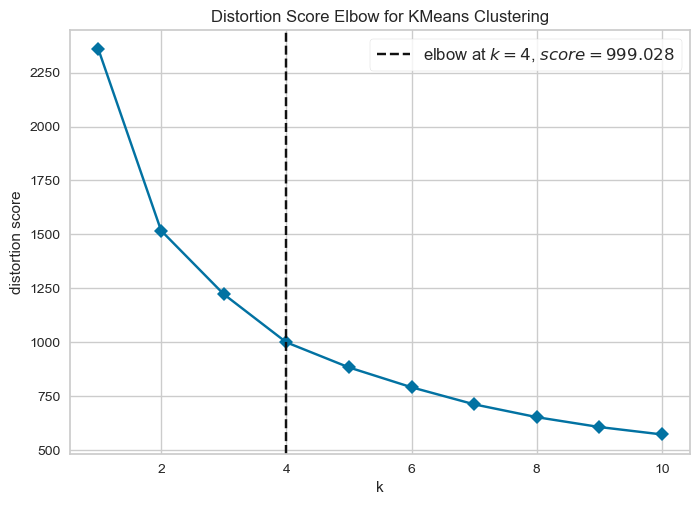

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [10]:
# Khởi tạo mô hình K-Means
model = KMeans()

# Sử dụng KElbowVisualizer để tìm k tối ưu với distortion (tương đương inertia)
visualizer = KElbowVisualizer(model, k=(1,11), timings=False)
visualizer.fit(rfm_scaled_df)
visualizer.show()

### **Áp dụng thuật toán K-means**

In [11]:
# Áp dụng K-means với số nhóm k = 4

kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=100, random_state=42)
clusters = kmeans.fit_predict(rfm_scaled_df)
rfm_scaled_df['Cluster'] = clusters
rfm_df['Cluster'] = clusters
rfm_df

c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


,makh,Recency,Frequency,Monetary,Cluster
0,KH-0001,32,14,2.531355e+09,3
1,KH-0002,29,10,1.017435e+09,1
2,KH-0003,11,6,2.130150e+08,1
3,KH-0004,62,13,1.054656e+10,3
4,KH-0005,7,20,6.737760e+09,0
...,...,...,...,...,...
781,KH-0782,35,10,2.438295e+09,1
782,KH-0783,21,15,5.383305e+09,3
783,KH-0784,14,21,2.727300e+09,0
784,KH-0785,47,12,3.914265e+09,3


***Trực quan hóa kết quả phân nhóm***

In [12]:
fig = px.scatter_3d(rfm_df, x='Recency', y='Frequency', z='Monetary', color='Cluster')
fig.show()


***Đánh giá chất lượng phân nhóm***

c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.

c:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

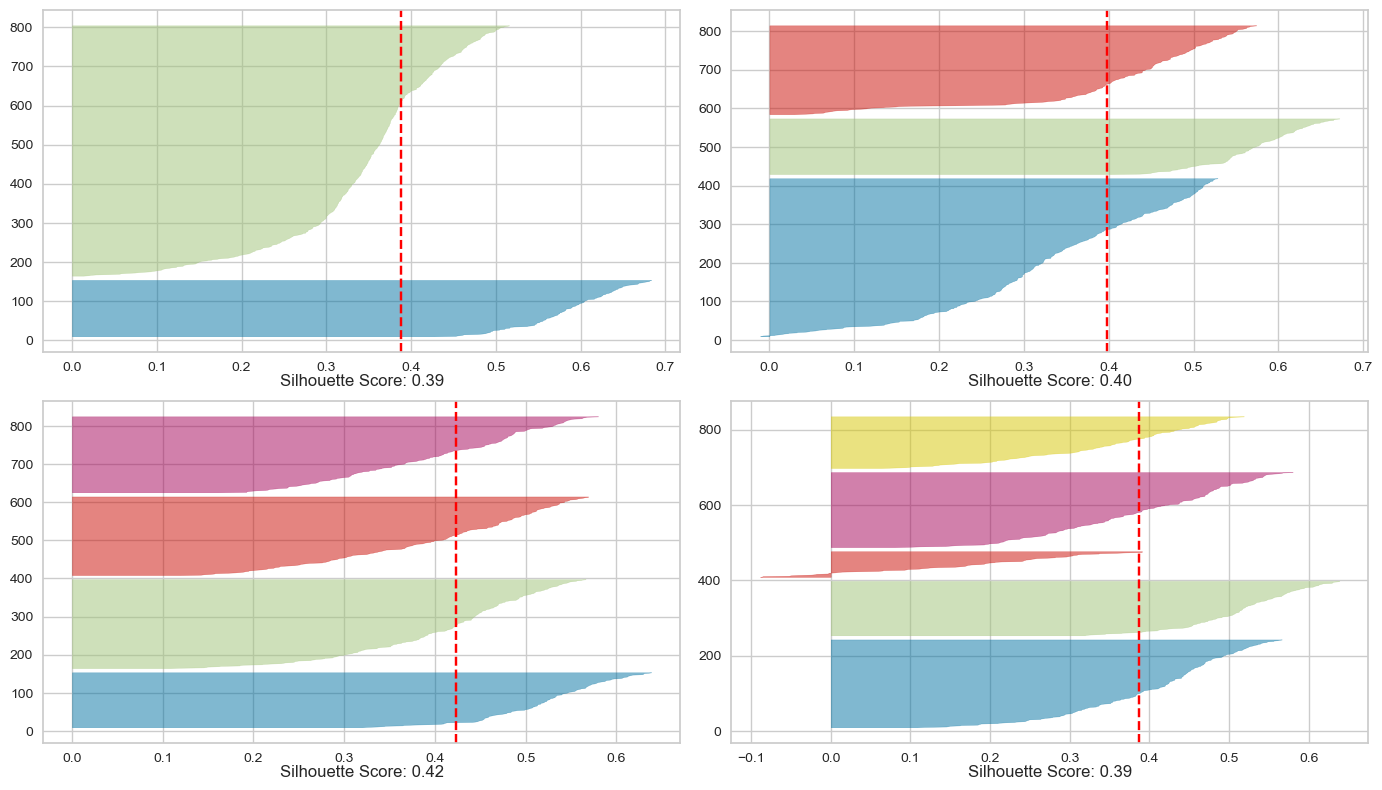

In [13]:
# vẽ Silhouette Visualizer cho các số nhóm k từ 2 đến 5.

# Visualize
fig, ax = plt.subplots(2, 2, figsize=(14, 8))  # Tạo bố cục 2x2 cho 4 biểu đồ
for idx, k in enumerate([2, 3, 4, 5]):
    km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state= 42)  # Khởi tạo mô hình KMeans
    q, mod = divmod(idx, 2)  # Để lấy chỉ số hàng và cột cho subplot

    # Visualizer
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q][mod])  # Tạo đối tượng SilhouetteVisualizer
    visualizer.fit(rfm_scaled_df)  # Fit vào dữ liệu đã chuẩn hóa

    # Hiển thị Silhouette Score trên biểu đồ
    ax[q][mod].text(0.5, -0.1, f'Silhouette Score: {np.mean(visualizer.silhouette_score_):.2f}', size=12,
                    ha='center', transform=ax[q][mod].transAxes)  # Thêm văn bản về Silhouette Score

# Tinh chỉnh bố cục và hiển thị các biểu đồ
plt.tight_layout()
plt.show()


### **Phân tích đặc điểm của các cụm**

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_4224\890690205.py:2: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



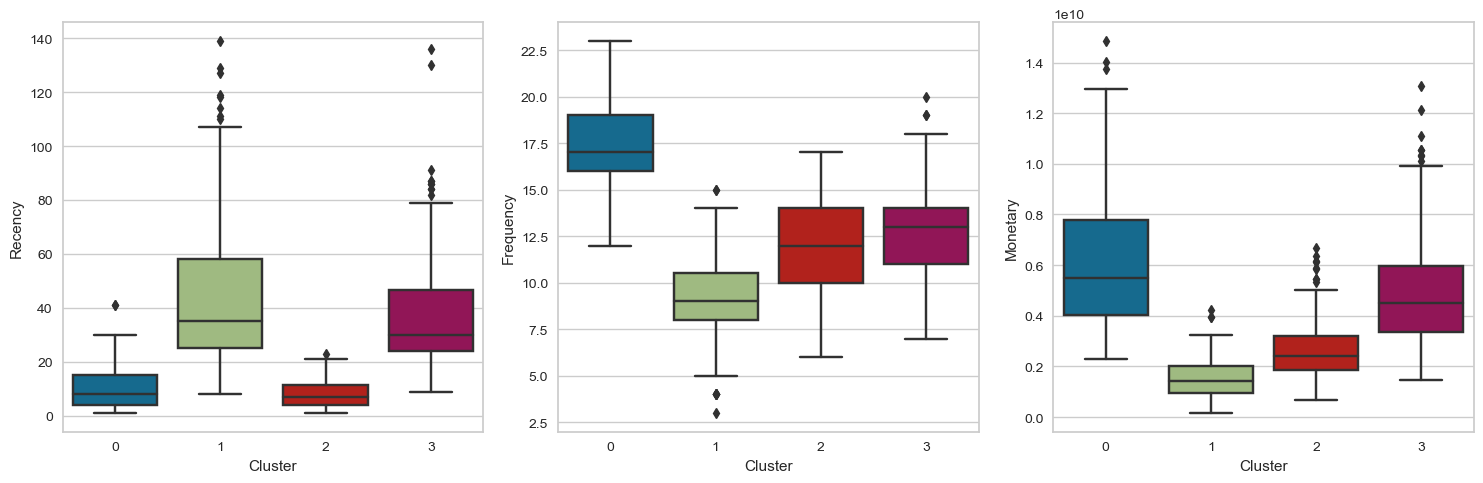

In [14]:
fig, ax = plt.subplots(figsize=(15, 5))  # Điều chỉnh kích thước của đồ thị
plt.subplot(1, 3, 1)
sns.boxplot(x='Cluster', y='Recency', data=rfm_df)  # Boxplot cho Recency
plt.subplot(1, 3, 2)
sns.boxplot(x='Cluster', y='Frequency', data=rfm_df)  # Boxplot cho Frequency
plt.subplot(1, 3, 3)  
sns.boxplot(x='Cluster', y='Monetary', data=rfm_df)  # Boxplot cho Monetary

plt.tight_layout() 
plt.show()  # Hiển thị biểu đồ


In [15]:
cluster_names = {0: 'Khách hàng trung thành', 
                 1: 'Khách hàng ít tương tác', 
                 2: 'Khách hàng mới', 
                 3: 'Khách hàng tiềm năng'}

rfm_df['Cluster'] = rfm_df['Cluster'].map(cluster_names)

In [16]:
rfm_df.to_csv('segment.csv', index = False)